In [129]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [130]:
om3 = [326, 447, 318, 481, 312, 304, 432, 461, 421, 423, 410, 447, 334, 487, 473, 368, 423, 493, 379, 424, 327, 475, 423, 445, 358, 387, 491, 396, 305, 352, 322, 381, 316, 488, 365, 371, 449, 337, 441, 349, 486, 370, 330, 488, 403, 426, 440, 356, 355, 467]

In [131]:
exps = [
    ["output_q=0.01_a=0.95_p=0_a_ratio=4_r_ratio=4"],
]

exp_names = ["InfluxDB"]
datasets=["manufacturing_exp" ]
labels = [
    ["VSCache", "M4"],
]

comps = [
    ["output"]
]

comp_results = [
    ["m4Results"]
]

m4 = [
    ["output"],
]

time_exps = [0]
memory_exps = []
time_per_op_exps = [0]
figsize = (10,4)
db = "influx"

In [132]:
dcts = [{
        'IO Count': 'mean',
        'Time (sec)': 'mean',
        'Query Time (sec)': 'mean',
        'Progressive Time (sec)': 'mean',
        'Memory': 'mean',
        'query #': 'mean',
        'width' : 'mean',
        'height' : 'mean',
        'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'from': 'mean',
        'to': 'mean',
        'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'Error': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
    }, 
        {
        'Time (sec)': 'mean',
        'query #': 'mean',
        'width' : 'mean',
        'height' : 'mean',
        'from': 'mean',
        'to': 'mean',
        'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
    },
    {
        'IO Count': 'mean',
        'Time (sec)': 'mean',
        'Memory': 'mean',
        'query #': 'mean',
        'width' : 'mean',
        'height' : 'mean',
        'from': 'mean',
        'to': 'mean',
        'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
        'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
    }]

In [133]:
def get_experiment_dfs(exp_id):
    data = [f"{exp}/timeQueries/{db}/" for exp in exps[exp_id]]
    names = os.listdir(os.path.join(data[0]))
    if '.DS_Store' in names: names.remove('.DS_Store')
    runs = list(np.sort(os.listdir(os.path.join(data[0], names[0]))))
    if '.DS_Store' in runs: runs.remove('.DS_Store')
    results = ["ttiMinMaxResults"]
    results_paths = [os.path.join(d, name, run, result)  for name in names for d in data for result in results for run in runs  ]
    dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
    dfs = []
    for i in range(0, len(dfs_all), len(runs)):
        dds = dfs_all[i : i + len(runs)]
        d = dds[0]
        if(len(runs) > 1):
            for j in range(1, len(runs)):
                d = pd.concat((d, dds[j]))
            if("raw" in results_paths[i]):
                dct = dcts[2]
            elif("m4" in results_paths[i]):
                dct = dcts[1]
            else:
                dct = dcts[0]
            d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dct.items()})
        dfs.append(d)
    return dfs, names


def get_competitor_dfs(exp_id):
    data = [f"{exp}/timeQueries/{db}/" for exp in comps[exp_id]]
    names = os.listdir(os.path.join(data[0]))
    if '.DS_Store' in names: names.remove('.DS_Store')
    runs = list(np.sort(os.listdir(os.path.join(data[0], names[0]))))
    if '.DS_Store' in runs: runs.remove('.DS_Store')
    results = comp_results[exp_id]
    results_paths = [os.path.join(d, name, run, result)  for name in names for d in data for result in results for run in runs  ]
    dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
    dfs = []
    for i in range(0, len(dfs_all), len(runs)):
        dds = dfs_all[i : i + len(runs)]
        d = dds[0]
        if(len(runs) > 1):
            for j in range(1, len(runs)):
                d = pd.concat((d, dds[j]))
            if("raw" in results_paths[i]):
                dct = dcts[2]
            elif("m4" in results_paths[i]):
                dct = dcts[1]
            else:
                dct = dcts[0]
            d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dct.items()})
        d = d.rename(columns={'Time (sec)': 'Query Time (sec)'})
        dfs.append(d)
    return dfs, names

def reorder_list(lst, n):
    result = []
    for i, val in enumerate(zip(*[iter(lst)] * n)):
        result.extend(val)
    return result

def get_dfs(exp_id):
    dfs, names = get_experiment_dfs(exp_id)
    dfs_comps, _ = get_competitor_dfs(exp_id)
    dfs.extend(dfs_comps)
    dfs = sorted(dfs, key=lambda x: x['dataset'].iloc[0])
    return dfs, names

In [134]:
def plot_time(dfs, name, exp_id):
    lbls = labels[exp_id]
    exp_name = exp_names[exp_id]

    plt.clf()
    sns.set(style="whitegrid")

    # Set a palette with more vibrant colors
    palette = sns.color_palette("tab10", n_colors=len(lbls))
    sns.set_palette(palette)

    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
    #fig.suptitle(f"Time per query, average time, and cumulative time in {name} dataset for {exp_name}", fontsize=14, fontweight='bold')

    times = []
    for i in range(len(lbls)):
        time = dfs[i]["Query Time (sec)"]
        times.append(time)
        sns.lineplot(data=time, ax=axs[0], label=lbls[i], linewidth=1, linestyle='-', alpha=0.8)  # Adjust line style and alpha as needed
        

    #bar_patterns = ['//', '\\\\', 'xx', '||', '*']  # List of line patterns for the bar plots
    axs[0].get_legend().remove()

    mean_matrix = []
    sum_matrix = []
    x_positions = []
    for i in range(len(lbls)):
        row1 = []
        row2 = []
        x_positions.append(i * (1 / len(lbls)))
        for j in range(len(lbls)):
            if i == j:
                row1.append(times[i].mean())
                row2.append(times[i].sum())
            else:
                row1.append(0)
                row2.append(0)
        mean_matrix.append(row1)
        sum_matrix.append(row2)
    for i in range(len(lbls)):
        # sns.barplot(x=x_positions, y=mean_matrix[i], ax=axs[1], color=palette[i], label=lbls[i],
        #             #hatch=bar_patterns[i]
        #            )  # Add hatch pattern to the bar plots
        sns.barplot(x=x_positions, y=sum_matrix[i], ax=axs[1], color=palette[i], label=lbls[i],
                    #hatch=bar_patterns[i]
                   )  # Add hatch pattern to the bar plots
    axs[1].set_xticklabels([])
    #axs[2].set_xticklabels([])

    # Create a custom legend with boxes representing the patterns
    handles, _ = axs[1].get_legend_handles_labels()
    custom_legend = plt.legend(handles, lbls, bbox_to_anchor=(1, 0.6), frameon=False)
    
    plt.setp(custom_legend.get_title(), fontweight='bold')  # Set legend title font weight

    for ax in axs:
        ax.spines['top'].set_visible(False)  # Remove top border
        ax.spines['right'].set_visible(False)  # Remove right border

    # Set axis labels and font size
    axs[0].set_xlabel('Query', fontsize=12)
    axs[0].set_ylabel('Time (sec)', fontsize=12)
    #axs[1].set_ylabel('Average Time (sec)', fontsize=12)
    axs[1].set_ylabel('Cumulative Time (sec)', fontsize=12)

    # Adjust spacing and margins
    fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
    plt.tight_layout()  # Adjust spacing and margins automatically

    # Save the plot as a PDF or other image format for high-quality output in the scientific paper
    plt.savefig(f'times/{exp_name}_{name}.png'.replace("%", ""), dpi=300)  # Adjust the filename and DPI as needed

    plt.show()
    
def plot_memory(dfs, name, exp_id):
    lbls = labels[exp_id]
    exp_name = exp_names[exp_id]
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"
    
    fig, axs = plt.subplots(1, 2, figsize = figsize, gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Memory and average memory in {name} dataset for {exp}")
    sns.lineplot(data=dfs[0]['Memory'], label=labels[0], ax=axs[0])
    sns.lineplot(data=dfs[1]['Memory'], label=labels[1], ax=axs[0])

    bar_colors = sns.color_palette("bright")  # Get the colors from the palette
    x_positions = [0, 1]
    sns.barplot(x=x_positions, y=[dfs[0]["Memory"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[1]["Memory"].mean()], ax=axs[1], color=bar_colors[1], label=labels[2])
    axs[1].set_xticklabels([])

    handles, l = axs[0].get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc=2, bbox_to_anchor=(0.9, 0.6))
    plt.show()
    
def plot_compaction(dfs, name, exp):
    plt.clf()
    sns.set(style="whitegrid")
    sns.set_palette("bright")  # Set the palette to "bright"
    
    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Data Compaction in {name} dataset")

    dfs[0]["TTI Compaction"] = dfs[0]["Results size"]/dfs[1]["Results size"]
    dfs[2]["M4 Compaction"] = dfs[2]["Results size"]/dfs[2]["Results size"]
    bar_colors = sns.color_palette("bright")  # Get the colors from the palette

    sns.lineplot(data=dfs[0]['TTI Compaction'], label=labels[0], ax=axs[0])
    sns.lineplot(data=dfs[2]['M4 Compaction'], color=bar_colors[2], label=labels[2], ax=axs[0])

    x_positions = [0, 1]
    sns.barplot(x=x_positions, y=[dfs[0]["TTI Compaction"].mean(), 0], ax=axs[1], color=bar_colors[0], label=labels[0])
    sns.barplot(x=x_positions, y=[0, dfs[2]["M4 Compaction"].mean()], ax=axs[1], color=bar_colors[2], label=labels[2])
    axs[1].set_xticklabels([])
    
    handles, l = axs[1].get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc=2, bbox_to_anchor=(0.9, 0.6))
    plt.show()
    

def plot_time_per_operation(dfs, name, exp_id):
    plt.clf()
    lbls = labels[exp_id]
    fig, axs = plt.subplots(1, len(dfs), figsize=(5*len(dfs), 5))
    fig.suptitle(f"Average time per operation in {name} dataset")

    operations = ['PAN', 'ZO', 'ZI']

    for i, df in enumerate(dfs):
        axs[i].set_title(f"Time per Operation type for {lbls[i]}")
        sns.boxplot(data=df, x='operation', y='Query Time (sec)', ax=axs[i])
    plt.tight_layout()
    plt.show()

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_82490/1070275616.py:68: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_82490/1070275616.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

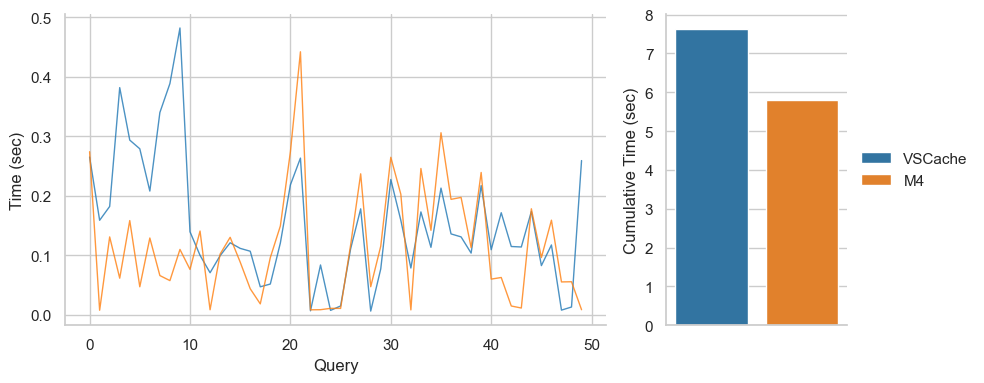

/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_82490/1070275616.py:68: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2, wspace=0.3)  # Adjust the bottom margin and horizontal spacing
/var/folders/cl/rlgfvqcj5bz8p2v_8qkjcb500000gn/T/ipykernel_82490/1070275616.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust spacing and margins automatically


<Figure size 640x480 with 0 Axes>

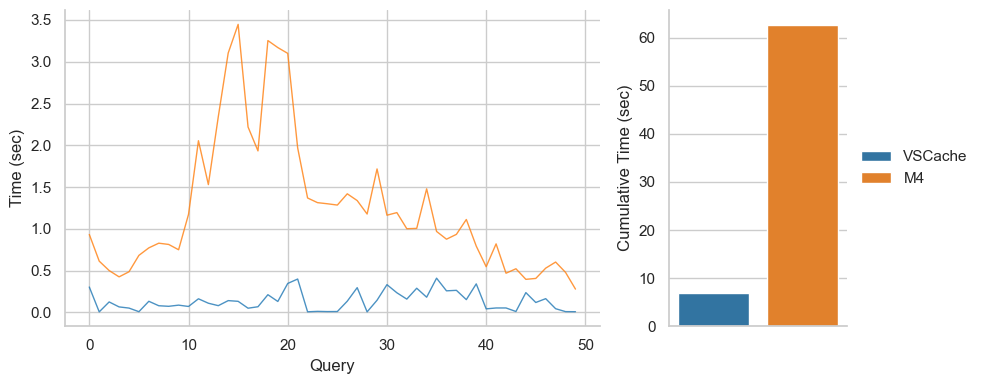

In [ ]:
for exp_id in time_exps:
    j = 0
    dfs, names = get_dfs(exp_id)
    for i in range(0, len(dfs), len(labels[exp_id])):
        plot_time(dfs[i : i + len(labels[exp_id])], names[j % len(names)], exp_id)
        j +=1

In [101]:
for exp_id in memory_exps:
    j = 0
    dfs, names = get_dfs(exp_id)
    for i in range(0, len(dfs), len(labels[exp_id])):
        plot_memory(dfs[i : i + len(labels[exp_id])], names[j % len(names)], exp_id)
        j +=1

<Figure size 640x480 with 0 Axes>

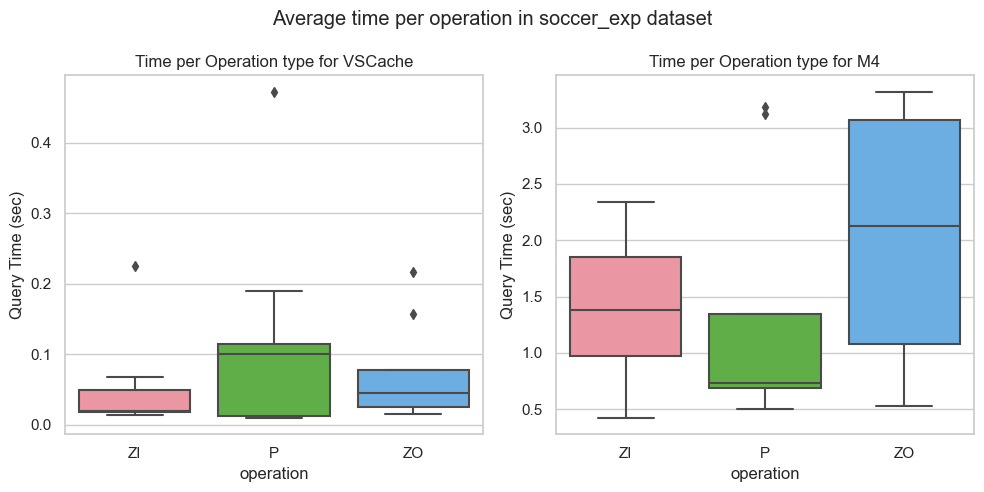

In [102]:
for exp_id in time_per_op_exps:
    j = 0
    dfs, names = get_dfs(exp_id)
    for i in range(0, len(dfs), len(labels[exp_id])):
        plot_time_per_operation(dfs[i : i + len(labels[exp_id])], names[j % len(names)], exp_id)
        j +=1

In [120]:
from skimage import io, color
from skimage.metrics import structural_similarity as compare_ssim
import cairo

def plot(df, measure, name, width, height, queryFrom, queryTo):
    # Define the surface and the context
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context(surface)
    
    ctx.set_antialias(cairo.Antialias.NONE)
    
    # Clear the background (white)
    ctx.set_source_rgb(1, 1, 1)
    ctx.paint()
    
    # Transform coordinate system so that (0,0) is the bottom left
    ctx.translate(0, height)
    ctx.scale(1, -1)
    
    # Plot the line (black)
    ctx.set_source_rgb(0, 0, 0)  # color
    ctx.set_line_width(1)  # line width
    
    pixelInterval = (queryTo - queryFrom) // width
    
    # Move to the first point
    ctx.move_to(
        np.floor((df['timestamp'].iloc[0] - queryFrom) / pixelInterval), 
        np.floor(height * ((df[measure].iloc[0] - df[measure].min()) / (df[measure].max() - df[measure].min())))
    )

    # Add lines to subsequent points
    for i in range(1, len(df)):
        ctx.line_to(
            np.floor((df['timestamp'].iloc[i] - queryFrom) / pixelInterval), 
            np.floor(height * ((df[measure].iloc[i] - df[measure].min()) / (df[measure].max() - df[measure].min())))
        )

    ctx.stroke()  # Apply the stroke
    
    # Save to a file
    surface.write_to_png(name + '.png')

    
    
def calculate_ssim(image_file1, image_file2, width, height):
    # Read the two images
    image1 = io.imread(image_file1)
    image2 = io.imread(image_file2)
    # Remove the alpha channel if present
    if image1.shape[2] == 4:
        image1 = image1[:, :, :3]
    if image2.shape[2] == 4:
        image2 = image2[:, :, :3]
    
    image1_gray = color.rgb2gray(image1)
    image2_gray = color.rgb2gray(image2)
    
    (score, _) = compare_ssim(image1_gray, image2_gray, full=True)
    # print(f"SSIM between {image_file1} and {image_file2}: {ssim_index:.4f}")
    diff = image1_gray - image2_gray
    # Search for all pixels that are different 
    # Type is <class 'numpy.ndarray'>, you can optionally convert to a list
    coords = np.argwhere(diff != 0)
    coords = coords.tolist() 
    return score, len(coords)/(width*height)


def get_mean_error(s, measures):
    a = (s.split("="))
    errs = []
    for l in a:
        if ("," in l):
            errs.append(float(l.split(",")[0]))
    errs.append(float(a[-1].split(",")[0][:-1]))
    return np.mean(errs)
    
    
def plot_indexes(dfs, name, exp_id):
    exp_name = exp_names[exp_id]
    lbls = labels[exp_id]


    fig, axs = plt.subplots(1, 1, figsize=(10, 8))

    tti_paths = [os.path.join(data, "timeQueries", db, name, "run_0", "ttiMinMaxResults") for data in exps[exp_id]]

    m4_paths = [os.path.join(data, "timeQueries", db, name, "run_0", "m4Results") for data in m4[exp_id]]

    tti_query_0 = [os.path.join(data, "query_0") for data in tti_paths]
    sql_query_0 = [os.path.join(data, "query_0") for data in m4_paths]

    meassure_files = os.listdir(tti_query_0[0])
    measures = [x.replace(".csv", "") for x in meassure_files]   
    queries = 50
    palette = sns.color_palette("tab10", n_colors=len(lbls))


    for i in range(len(dfs)):
        tti_path1 = tti_paths[i]
        m4_path = m4_paths[i]
        df1 = dfs[i]
        errors1 = df1['Error'].apply(get_mean_error, args=([measures]))
        ssims = []
        diffs = []
        for n in range(queries):
            q = f"query_{n}"
            j = 0
            ssim1 = 0
            diffs1 = 0
            for m in meassure_files:
                path_tti1 = os.path.join(tti_path1, q)
                path_sql = os.path.join(m4_path, q)

                df_tti1 = pd.read_csv(os.path.join(path_tti1, m))
                df_m4 = pd.read_csv(os.path.join(path_sql, m))

                width = int(df1['width'][0])
                height = int(df1['height'][0])
                queryFrom = int(df1['from'][i])
                queryTo = int(df1['to'][i])
                plot(df_tti1, measures[j], f"plots/{q}-{measures[j]}-tti1",width,height, queryFrom, queryTo)
                plot(df_m4, measures[j], f"plots/{q}-{measures[j]}-m4", width, height, queryFrom, queryTo)
                score1, diff1 = calculate_ssim(f"plots/{q}-{measures[j]}-tti1.png", f"plots/{q}-{measures[j]}-m4.png", width, height)

                ssim1 += score1
                diffs1 += diff1
                j+=1  
            avg_ssim1 = ssim1 / len(measures)
            avg_diff1 = diffs1 / len(measures)
            ssims.append(avg_ssim1)
            diffs.append(avg_diff1)
        axs.plot(ssims, label=f"SSIM-{lbls[i]}", linewidth=2.5, color=palette[i], linestyle="--", marker = "o")
        axs.plot(diffs, label=f"Difference-{lbls[i]}", linewidth=2.5, color=palette[i])
        axs.plot(errors1, label=f"Max Error-{lbls[i]}", linewidth=2.5, linestyle="--")

    # Remove spines
    sns.despine()

    # Set x-axis ticks
    axs.set_xticks([0, 10, 20, 30, 40, 50])
    # Set x-axis tick labels as 'query_{q}'
    #axs.set_xticklabels([f'{i}:{dfs[0].operation[i]}' for i in range(len(df1))], rotation=45)
        
    # Legend adjustments
    handles, l = axs.get_legend_handles_labels()
    custom_legend = plt.legend(handles, l, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.savefig(f'ssims/{exp_name}_{name}.png'.replace("%", ""), dpi=300)  # Adjust the filename and DPI as needed

    plt.show()

IndexError: list index out of range

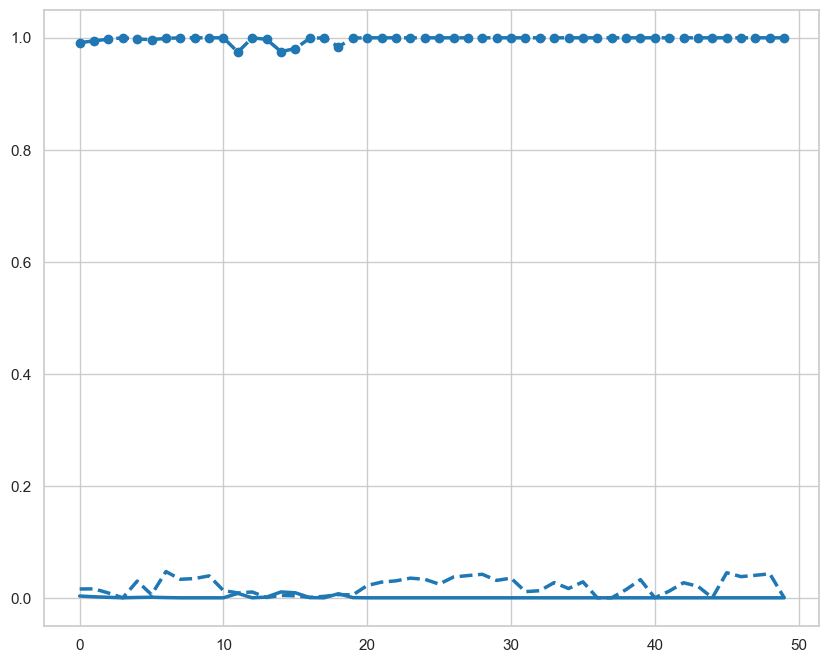

In [121]:
for exp_id in time_exps:
    j = 0
    dfs, names = get_dfs(exp_id)
    for i in range(0, len(dfs), len(labels[exp_id])):
        plot_indexes(dfs[i : i + len(labels[exp_id])], names[j % len(names)], exp_id)
        j +=1